In [1]:
import numpy
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import sys
import cv2

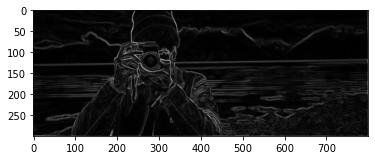

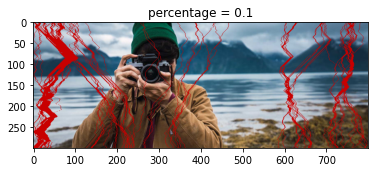

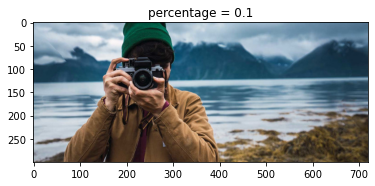

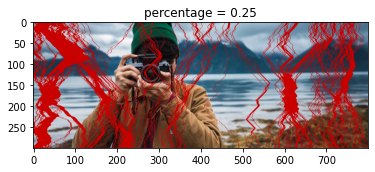

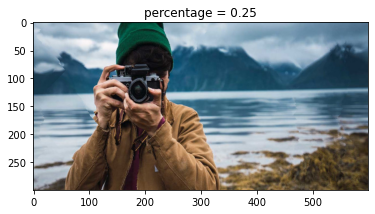

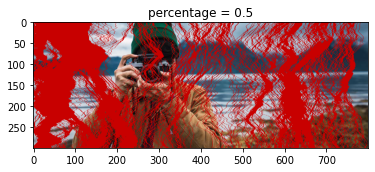

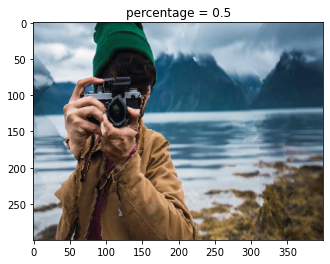

In [16]:
def find_energy_map(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernelx = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    kernely = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    gradx = convolve2d(gray, kernelx, 'same')
    grady = convolve2d(gray, kernely, 'same')
    grad = np.absolute(gradx) + np.absolute(grady)

    return grad


def find_vertical_seam(energy):
    row = energy.shape[0]
    col = energy.shape[1]
    dp_energy = []
    dp_energy.append(energy[0].tolist())
    for i in range(1, row):
        temp = []
        for j in range(col):
            if j == 0:
                temp.append(energy[i][j] + min(dp_energy[i - 1][j], dp_energy[i - 1][j + 1]))
            elif j == col - 1:
                temp.append(energy[i][j] + min(dp_energy[i - 1][j], dp_energy[i - 1][j - 1]))
            else:
                temp.append(energy[i][j] + min(dp_energy[i - 1][j - 1], dp_energy[i - 1][j], dp_energy[i - 1][j + 1]))
        dp_energy.append(temp)

    seam = [0] * row
    seam[row - 1] = np.argmin(dp_energy[row - 1])
    for i in range(row - 2, -1, -1):
        j = seam[i + 1]
        if j == 0:
            seam[i] = np.argmin(dp_energy[i][j:j + 2]) + j
        elif j == col - 1:
            seam[i] = np.argmin(dp_energy[i][j - 1:j + 1]) + j - 1
        else:
            seam[i] = np.argmin(dp_energy[i][j - 1:j + 2]) + j - 1
    return np.array(seam)


def remove_vertical_seam(image, seam):
    height = image.shape[0]
    linear_inds = np.array(seam)+np.arange(image.shape[0])*image.shape[1]
    new_image = np.zeros((height,image.shape[1]-1), dtype="uint8")
    new_image = np.delete(image, linear_inds.astype(int))
    new_image = np.reshape(new_image, (height, image.shape[1]-1))
    return new_image

def find_seams_list(energy_map, seam_dir, seam_num):

    if seam_dir == 'horizontal':
        energy_map = cv2.rotate(energy_map,cv2.ROTATE_90_CLOCKWISE)
    index_map = np.zeros(energy_map.shape)
    seems_list = []
    for j in range(1,seam_num+1):
        seam = find_vertical_seam(energy_map)
        energy_map = remove_vertical_seam(energy_map,seam)
        for i in range(len(seam)):
            seam[i] += len(np.where(index_map[i,:seam[i]]!=0)[0])
            modified_col = seam[i]
            while index_map[i,modified_col] != 0:
                modified_col +=1
            seam[i] = modified_col
            index_map[i,seam[i]] = j
        seems_list.append(seam)

    seems_list = np.array(seems_list).T
    index_map = np.array(index_map)

    if seam_dir == 'horizontal':
        seems_list = seems_list.T
    return seems_list, index_map

def remove_seams(image, seams_list, seam_dir, index_map):
    image = image.copy()

    if seam_dir == 'horizontal':
        image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
        seams_list = seams_list.T
    new_image = np.zeros(shape=(image.shape[0],image.shape[1]-seams_list.shape[1],3))
    for i in range(len(image)):
        new_image[i] = numpy.delete(image[i],seams_list[i],axis=0)

    image[np.where(index_map != 0)] = (200, 0, 0)

    if seam_dir == 'horizontal':
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if seam_dir == 'horizontal':
        return cv2.rotate(new_image, cv2.ROTATE_90_COUNTERCLOCKWISE), image
    else:
        return new_image, image


img = cv2.imread('new.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

percentages = [0.10,0.25,0.5]
dir = 'vertical'


seem_nums = [int(x*img.shape[1]) for x in percentages]


energy_map = find_energy_map(img)
plt.figure()
plt.imshow(energy_map, cmap='gray')
plt.show()


seams_list, index_map = find_seams_list(energy_map,dir,max(seem_nums))

for i in range(len(seem_nums)):

    if dir == 'horizontal':
        seams_list_new = seams_list[:seem_nums[i],:]
    else:
        seams_list_new = seams_list[:,:seem_nums[i]]

    new_index_map = index_map.copy()
    new_index_map[new_index_map>seem_nums[i]] = 0
    resized_image,seems_image = remove_seams(img,seams_list_new,dir,new_index_map)
    plt.figure()
    plt.imshow(seems_image)
    plt.title(f'percentage = {percentages[i]}')
    plt.show()

    plt.figure()
    plt.imshow(resized_image.astype(int))
    plt.title(f'percentage = {percentages[i]}')
    plt.show()